# Rigorozní odhady prvního vlastního čísla p-laplaciánu 

## varianta $u_1$, $u_2$

Řešíme úlohu 
\begin{equation}
-\Delta_p u =\lambda |u|^{p-2}u, \; t \in (0,1)\\
u(0)=u(1)=0
\end{equation}
kde $\Delta_p u := \left(|u'|^{p-2}u' \right)'$.

Přesná hodnota prvního vlastního čísla je:

$$\lambda_1 = (p-1)\left( \frac{2\frac{\pi/p}{\sin{\pi/p}}}{b-a} \right)^p,$$

přesná hodnota první vlastní funkce:

$$e_p =(p-1)^{-\frac{1}{p}} \sin_p{\left( \pi_p\frac{x-a}{b-a} \right)}$$


![vl-cislo-fce](vl-cislo-fce.png)

### Algoritmus:
1. úlohu vyřešit numericky metodou střelby
2. získané řešení $u_1 := u$ a $u_2 := |u_1'|^{p-2}u_1'$ proložit intervalově křivkou (kubický spline?)
3. $v$ zderivovat - půjde snadno, je to polynom
4. dosadit do vztahu pro horní/dolní odhad a intervalově vypočítat

#### Postup pro řešení pomocí shooting method:
- převedu na soustavu:
\begin{equation}
u_1' = |u_2|^{\frac{p}{p-1}-2} u_2\\
u_2' = -\lambda |u_1|^{p-2}u_1
\end{equation}
- tu řeším jako IVP s levou okrajovou podmínkou a nějakým pevným $\lambda$
- bisekcí měním $\lambda$ až se napravo dostanu kam potřebuju ($u_1=0$)


#### Problémy:
- je vůbec možné použít $u_2$? Je to zaručená derivace vnitřku $\Delta_p u$?
- u kubického splinu pro $u_1$ chci nastavit duhou derivaci na $-1$. Co to ale znamená pro křivku proloženou numerickým řešení $u_2$ vzhledem k $p$ a $\Delta_p$?

In [156]:
using DifferentialEquations
using Plots; gr()
using IntervalArithmetic
using DataInterpolations
using LinearAlgebra
using ForwardDiff

Nejprve si nastavím $p=3$. Zatím pracuji jen s $p>2$ a s $p \in \mathbb{N}$.

In [376]:
# nastavení p a přesná hodnota λ₁
P=2
λ1 = (P-1)*(2*(π/P)/(sin(π/P)))^P

9.869604401089358

In [466]:
# nastavení základních parametrů
tn = 21 # kroků dělení
xn = 201 # dělení jednotlivého oblouku spline

α = 0.001 - 7e-4 # kolik budeme přičítat k řešení
#dd = 

a,b = (3.,30.); # interval na kterém hledá λ₁ (nesmí obsahovat i λ₂, jinak to můž najít to)

Numerické řešení přes střelbu. 

Počáteční podmínka nastavena na $\boldsymbol{u}_0 = (0, 1)$, časový krok $\Delta t = 0.01$

---

Zatím to vypadá, že řešení IVP v Julii funguje jen pro P>=2 (případ P=2 nás ale vlastně nezajímá). Zjistit, proš nefunguje řešení pro 1<P<2

- důvod je v tom, že počáteční podmínka pro $u_1$ je $u_1(0)=0$ a tak v druhé rovnici hned na začátku dělím nulou. Řešením je to trochu posunout nahoru, ale to je pak řešení úplně blbě. Zkusím to ještě konfigurací řešiče
    - možná by stačilo nějak řešiči říct, ať to _neřeší_ v prvním bodě, někdo to v těch parametrech bylo

Numericky získané první vlastní číslo λ₁: 9.869604401131411
Chyba proti přesnému řešení: -4.205347181596153e-11


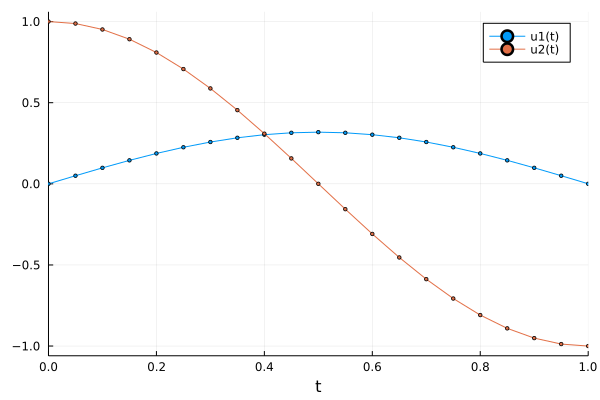

In [467]:
# řešení diferenciální soustavy metodou střelby

function sl(du,u,p,t) # parametr p je odhad na λ₁ a p z p-laplacianu
    λ, r = p
    du[1] = abs(u[2])^(1/(r-1)) * sign(u[2])
	du[2] = -λ * abs(u[1])^(r-1)*sign(u[1]) # abs mohu pro u₁ vynechat, protože je vždy kladné
end

u0 = [0.0; 1.0;] # počáteční podmínka

s = (a + b)/2
ts = 1.0/(tn-1) # velikost intervalu dělení


e = 1e-12 # zastavovací podmínka

while (b-a) >= e
    prob = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
    sol = solve(prob, saveat=ts, abstol=1e-8,reltol=1e-8)

    if sol(1)[1] == 0 # bere hodnotu v t=1 (pravej konec) pro první řešení soustavy u₁
        break
    else
        probA = ODEProblem(sl, u0, (0.0, 1.0), (a, P))
        solA = solve(probA, saveat=ts, abstol=1e-8,reltol=1e-8)
        
        probS = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
        solS = solve(probS, saveat=ts, abstol=1e-8,reltol=1e-8)

        if solA(1)[1] * solS(1)[1] < 0
            b = s
        else
            a = s
        end
        s = (a+b)/2
    end
end
    
prob = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
sol = solve(prob, saveat=ts, abstol=1e-8,reltol=1e-8)

println("Numericky získané první vlastní číslo λ₁: $s")
println("Chyba proti přesnému řešení: $(λ1-s)")
plot(sol,marker=2)

Vytáhnu si řešení do proměnných t, a u2. 

---> zatím ne: K u1 přičtu nějakou malou hodnotu aby posléze spline nelezl intervalově pod $0$. 

In [468]:


t = sol.t
ti = [@interval(i) for i in t]

u2 = [u[2] for u in sol.u]
u2i = [@interval(u[2]) for u in sol.u];




Intervalově vypočítáme kubický spline pro numerické řešení $u_2$.

In [469]:
#matice A
n=length(u2i)
dv = [4 for i in 1:n-2]
ev = [1 for i in 1:n-3]
A = Array(SymTridiagonal(dv,ev))
A_inv = inv(A) #inverze

#pravá strana
h = ts
# sestavení pravé strany
rhs = []
for i in 3:length(u2i)
    append!(rhs, 6/h^2 * (u2i[i] - 2 * u2i[i-1] + u2i[i-2]))
end

# vypočte vektor druhých derivací potřebný na výpočet koeficientů
# druhá derivace na krajích je nastavena na -1

d2v = []
append!(d2v, @interval(0)) # druhou derivaci nastavíme na přihbližnou hodnotu λ₁
append!(d2v, A_inv*rhs)
append!(d2v, @interval(0))#-1));

# výpočet koeficientů jednotlivých oblouků splinu
csc_u2 = [] #@interval zeros(4, length(solu)-1)
for i in 1:length(u2i)-1
    a=b=c=d=0
    a = (d2v[i+1]-d2v[i])/(6*h)
    b = d2v[i]/2 
    c = (u2i[i+1] - u2i[i])/h - h*(2*d2v[i]+d2v[i+1])/6
    d = u2i[i]
    append!(csc_u2, [[a,b,c,d]])
    #csc[1, i] = a
end
csc_u2

20-element Vector{Any}:
 Interval{Float64}[[-41.3939, -41.3938], [0, 0], [-0.142749, -0.142748], [1, 1]]
 Interval{Float64}[[12.4078, 12.4079], [-6.20908, -6.20907], [-0.453203, -0.453202], [0.987688, 0.987689]]
 Interval{Float64}[[-1.02146, -1.02145], [-4.34791, -4.3479], [-0.981052, -0.981051], [0.951056, 0.951057]]
 Interval{Float64}[[3.50703, 3.50704], [-4.50112, -4.50111], [-1.42351, -1.4235], [0.891006, 0.891007]]
 Interval{Float64}[[3.14414, 3.14415], [-3.97507, -3.97506], [-1.84732, -1.84731], [0.809016, 0.809017]]
 Interval{Float64}[[3.99133, 3.99134], [-3.50345, -3.50344], [-2.22124, -2.22123], [0.707106, 0.707107]]
 Interval{Float64}[[4.39526, 4.39527], [-2.90475, -2.90474], [-2.54165, -2.54164], [0.587785, 0.587786]]
 Interval{Float64}[[4.78339, 4.7834], [-2.24546, -2.24545], [-2.79916, -2.79915], [0.45399, 0.453991]]
 Interval{Float64}[[5.029, 5.02901], [-1.52795, -1.52794], [-2.98783, -2.98782], [0.309016, 0.309017]]
 Interval{Float64}[[5.15729, 5.1573], [-0.773595, -0.77

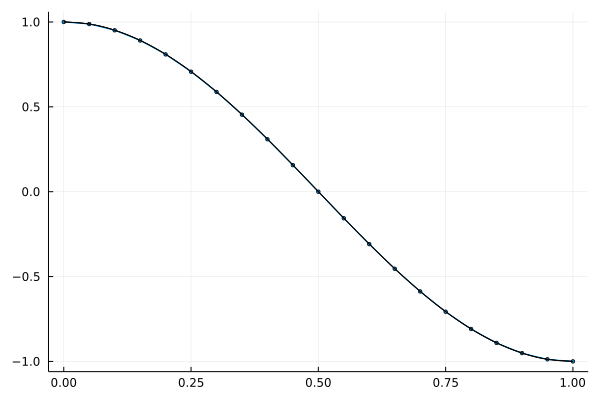

In [470]:
# napočítání a
# vykreslení řešení aproximovaného přes kubický spline



p = plot(t,u2, marker=2)
u2spl = Interval[]
for i in 1:length(u2i)-1
    x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
    x_int = mince(x_dom,xn)
    f(x) = csc_u2[i][1]*(x-ti[i])^3 + csc_u2[i][2]*(x-ti[i])^2 + csc_u2[i][3]*(x-ti[i]) + csc_u2[i][4]
    append!(u2spl, f.(x_int))
    boxes = IntervalBox.(x_int, f.(x_int))    
    plot!(boxes, legend=false)
end

tints = mince(0..1,(tn-1)*xn) # časové dělení
p

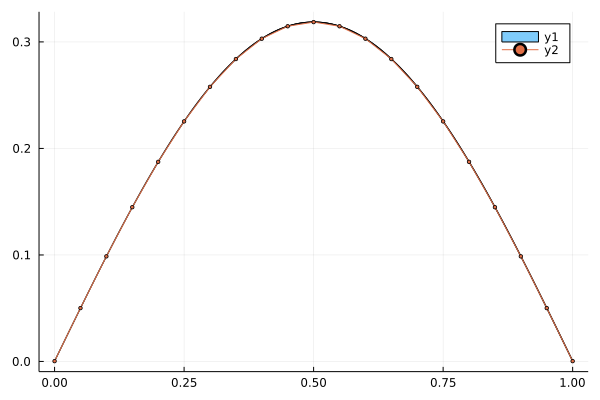

In [471]:
f(x) = abs(x)^(1/(P-1))*sign(x)
#sum(f.(u2spl) .* diam.(tints))

u1tmp = Interval[0..0]
for i in 1:length(u2spl)
    append!(u1tmp, u1tmp[end] + f(u2spl[i]) * diam(tints[i]))
end

u1int = Interval[]
for i in 1:length(u1tmp)-1
    append!(u1int, u1tmp[i] ∪ u1tmp[i+1])
end

u1int = u1int .+ α

boxes = IntervalBox.(tints, u1int)
plot(boxes)
plot!(t, [u[1]+α for u in sol.u], marker=2)


In [472]:
u1int

4020-element Vector{Interval{Float64}}:
 [0.0003, 0.000548757]
 [0.000548747, 0.000797504]
 [0.000797485, 0.00104625]
 [0.00104621, 0.00129498]
 [0.00129493, 0.0015437]
 [0.00154364, 0.00179241]
 [0.00179235, 0.00204111]
 [0.00204104, 0.00228981]
 [0.00228973, 0.00253849]
 [0.0025384, 0.00278717]
 [0.00278707, 0.00303584]
 [0.00303573, 0.0032845]
 [0.00328438, 0.00353315]
  ⋮
 [0.002766, 0.00355418]
 [0.0025173, 0.00330557]
 [0.00226858, 0.00305694]
 [0.00201986, 0.00280831]
 [0.00177113, 0.00255967]
 [0.00152239, 0.00231102]
 [0.00127364, 0.00206237]
 [0.00102488, 0.0018137]
 [0.000776118, 0.00156503]
 [0.000527342, 0.00131634]
 [0.000278556, 0.00106765]
 [2.97621e-05, 0.000818947]

In [473]:
# spočítat druhou derivaci u2spl z koeficientů = p-laplacian
csc_u2der =[ [@interval(3) * cs[1], @interval(2) * cs[2], cs[3]] for cs in csc_u2 ]

20-element Vector{Vector{Interval{Float64}}}:
 [[-124.182, -124.181], [0, 0], [-0.142749, -0.142748]]
 [[37.2234, 37.2235], [-12.4182, -12.4181], [-0.453203, -0.453202]]
 [[-3.06436, -3.06435], [-8.69581, -8.6958], [-0.981052, -0.981051]]
 [[10.5211, 10.5212], [-9.00224, -9.00223], [-1.42351, -1.4235]]
 [[9.43242, 9.43243], [-7.95013, -7.95012], [-1.84732, -1.84731]]
 [[11.9739, 11.974], [-7.00689, -7.00688], [-2.22124, -2.22123]]
 [[13.1857, 13.1858], [-5.80949, -5.80948], [-2.54165, -2.54164]]
 [[14.3501, 14.3502], [-4.49091, -4.4909], [-2.79916, -2.79915]]
 [[15.087, 15.0871], [-3.0559, -3.05589], [-2.98783, -2.98782]]
 [[15.4718, 15.4719], [-1.54719, -1.54718], [-3.10291, -3.1029]]
 [[15.4718, 15.4719], [-1.90982e-10, -1.90838e-10], [-3.14159, -3.14158]]
 [[15.087, 15.0871], [1.54718, 1.54719], [-3.10291, -3.1029]]
 [[14.3501, 14.3502], [3.05589, 3.0559], [-2.98783, -2.98782]]
 [[13.1857, 13.1858], [4.4909, 4.49091], [-2.79916, -2.79915]]
 [[11.9739, 11.974], [5.80948, 5.80949], [-

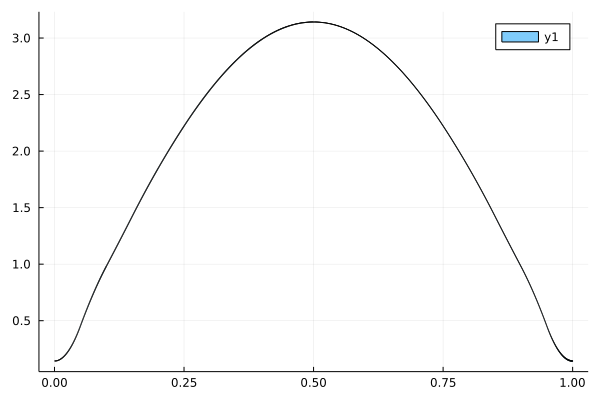

In [474]:
# naúočítat si vektor intervalů
# vypočítat hodnoty piconeho jako podíl 2 vektorů intervalů

# výpočet λ₁ - dolní odhad

# vykreslení řešení aproximovaného přes kubický spline


numer = Interval[]
#p = plot()#t, [λ1 for i in t])
for i in 1:length(u2i)-1
    x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
    x_int = mince(x_dom,xn)
    
    #u1_spl(x) = csc_u1[i][1]*(x-ti[i])^3 + csc_u1[i][2]*(x-ti[i])^2 + csc_u1[i][3]*(x-ti[i]) + csc_u1[i][4]

    #u2der_spl(x) = -(csc_u2der[i][1]*(x-ti[i])^2 + csc_u2der[i][2]*(x-ti[i]) + csc_u2der[i][3])
    f(x) = -(csc_u2der[i][1]*(x-ti[i])^2 + csc_u2der[i][2]*(x-ti[i]) + csc_u2der[i][3])
    #f(x)         = -(csc_u2der[i][1]*(x-ti[i])^2 + csc_u2der[i][2]*(x-ti[i]) + csc_u2der[i][3])    

    #f(x) = u2der_spl(x) / u1_spl(x) #^(P-1)
    #println(-v_spl_der_i(x_int[1]))
    #println(u_spl_i(x_int[1]))
    boxes = IntervalBox.(x_int, f.(x_int))    
    
    #if i == length(u2i)-1
    #    println(u2der_spl(x_int[end]))
    #    println(u1_spl(x_int[end]))        
    #    println(boxes[end])
    #end
    
    #plot!(boxes, legend=false)
    # kromě vykreslení sem musím ještě dodat záznam minim
    append!(numer, f.(x_int))
    
end
#println("Dolní odhad λ₁: $(minimum(ls))")
#println("Chyba proti přesné hodnotě λ₁: $(λ1 - minimum(ls))")
plot(IntervalBox.(tints, numer))


In [475]:
numer

4020-element Vector{Interval}:
 [0.142748, 0.142757]
 [0.142756, 0.14278]
 [0.142779, 0.142818]
 [0.142817, 0.142872]
 [0.142871, 0.142941]
 [0.14294, 0.143026]
 [0.143025, 0.143126]
 [0.143125, 0.143241]
 [0.14324, 0.143372]
 [0.143371, 0.143518]
 [0.143517, 0.143679]
 [0.143678, 0.143856]
 [0.143855, 0.144048]
  ⋮
 [0.140766, 0.146768]
 [0.140589, 0.146607]
 [0.140427, 0.146461]
 [0.140281, 0.14633]
 [0.140151, 0.146215]
 [0.140036, 0.146115]
 [0.139936, 0.14603]
 [0.139851, 0.145961]
 [0.139782, 0.145907]
 [0.139728, 0.145869]
 [0.13969, 0.145846]
 [0.139667, 0.145838]

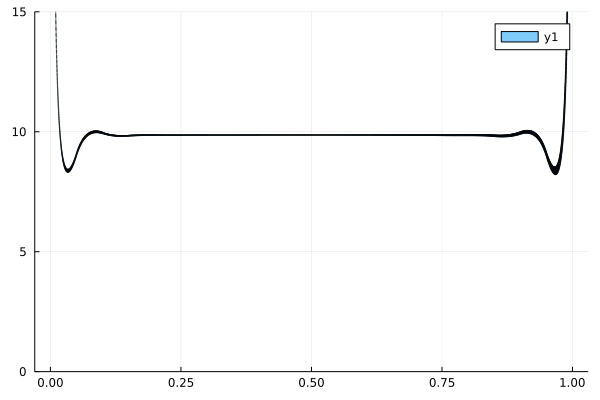

In [476]:
f(x,y) = x / y^(P-1)
picone = f.(numer, u1int)
boxes = IntervalBox.(tints, f.(numer, u1int))
plot(boxes, ylim=(0,15))

In [477]:
println("Minimium na začátku: $(minimum(picone[1:500]))")
println("Minimium na konci: $(minimum(picone[320:end]))")

Minimium na začátku: [8.30821, 8.43142]
Minimium na konci: [8.21156, 8.5271]


# KONEC
----

Intervalově vyjádříme $u_1$ z $u_2$ jako:

$$u_1(t) = \alpha + \int_0^t |u_2(s)|^{\frac{1}{p-1}}\text{sgn}\,u_2(s)\, ds$$

V intervalové aritmetice:

$$u_1(a..b) = \alpha + |u_2(a..b)|^{\frac{1}{p-1}}\text{sgn}\,u_2(a..b) * \text{diam}(a..b)$$

In [120]:
u1spl = Interval[0..0] # ∪ abs(u2spl[1])^(1/(P-1))*sign(u2spl[1])*diam(tints[1])
u1prev = 0..0

for i in 2:length(u2spl)#
   #append!(u1spl, abs(u2spl[i])^(1/(P-1))*sign(u2spl[i]))*diam(tints[i])

    u1_tmp = u1spl[end]+ abs(u2spl[i])^(1/(P-1))*sign(u2spl[i])*diam(tints[i])#u1spl[end] +abs(u2spl[i])^(1/(P-1))*sign(u2spl[i])*diam(tints[i])
   
    #println(u1_tmp ∩ u1spl[end])
    
    #if u1_tmp ∩ u1spl[end] == ∅
    #    println("$i JE PRAZDNÁ")
    #    if sup(u1spl[end]) <= inf(u1_tmp)
    #        u1_tmp = sup(u1spl[end])..sup(u1_tmp)
    #    else
    #        u1_tmp = sup(u1spl[end])..sup(u1_tmp)
    #    end
    #end
    #u1_tmp = sup(u1spl[end])..sup(u1_tmp)
    append!(u1spl, u1prev ∪ u1_tmp)
    u1prev = inf(u1_tmp)..sup(u1_tmp)
end
#bbb = IntervalBox.(tints, u1spl)
#plot(bbb)


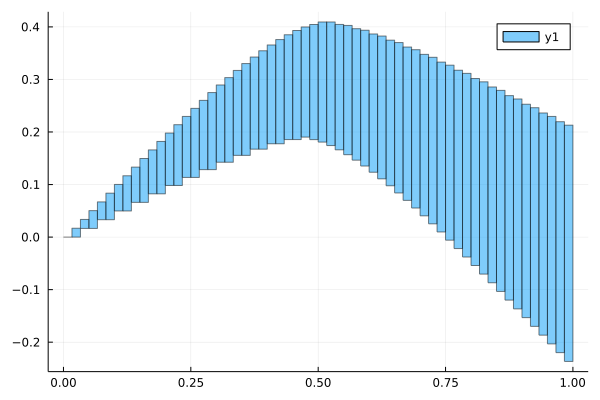

In [121]:
bbb = IntervalBox.(tints, u1spl[1:end])
plot(bbb)

In [110]:
testu = Interval[]
for i in 1:length(u1spl)
   
end
testu

60-element Vector{Interval}:
  [0.0166319, 0.0167395]
  [0.0332324, 0.0335378]
  [0.0497528, 0.0503674]
  [0.0663962, 0.0670243]
  [0.0830173, 0.0836676]
  [0.0996053, 0.100289]
  [0.116147, 0.116877]
  [0.132626, 0.133419]
  [0.149027, 0.149899]
  [0.165328, 0.166299]
  [0.181506, 0.1826]
  [0.197538, 0.198779]
  [0.213396, 0.214811]
   ⋮
  [0.159467, 0.2047]
  [0.143127, 0.188559]
  [0.126664, 0.172323]
  [0.110174, 0.155932]
  [0.0936036, 0.139482]
  [0.0769672, 0.122989]
  [0.0603395, 0.106407]
  [0.0436766, 0.0898052]
  [0.0269871, 0.0731946]
  [0.0103261, 0.0565659]
 [-0.0063363, 0.0399679]
 [-0.0230442, 0.0233817]

In [ ]:
# i z u1spl udělat spline - tohle spíš ne, stačí ty intervaly

In [ ]:
# derivovat u2spl

In [ ]:
# dosadit do piconeho

Derivace $u_2$

In [91]:
csc_u2der =[ [@interval(3) * cs[1], @interval(2) * cs[2], cs[3]] for cs in csc_u2 ]

20-element Vector{Vector{Interval{Float64}}}:
 [[-24.1815, -24.1814], [-10, -10], [0.023918, 0.0239181]]
 [[37.2234, 37.2235], [-12.4182, -12.4181], [-0.453203, -0.453202]]
 [[-3.06436, -3.06435], [-8.69581, -8.6958], [-0.981052, -0.981051]]
 [[10.5211, 10.5212], [-9.00224, -9.00223], [-1.42351, -1.4235]]
 [[9.43242, 9.43243], [-7.95013, -7.95012], [-1.84732, -1.84731]]
 [[11.9739, 11.974], [-7.00689, -7.00688], [-2.22124, -2.22123]]
 [[13.1857, 13.1858], [-5.80949, -5.80948], [-2.54165, -2.54164]]
 [[14.3501, 14.3502], [-4.49091, -4.4909], [-2.79916, -2.79915]]
 [[15.087, 15.0871], [-3.0559, -3.05589], [-2.98783, -2.98782]]
 [[15.4718, 15.4719], [-1.54719, -1.54718], [-3.10291, -3.1029]]
 [[15.4718, 15.4719], [-1.76172e-10, -1.76028e-10], [-3.14159, -3.14158]]
 [[15.087, 15.0871], [1.54718, 1.54719], [-3.10291, -3.1029]]
 [[14.3501, 14.3502], [3.05589, 3.0559], [-2.98783, -2.98782]]
 [[13.1857, 13.1858], [4.4909, 4.49091], [-2.79916, -2.79915]]
 [[11.9739, 11.974], [5.80948, 5.80949],

[0.983333, 1] × [-2.26868, 601.471]


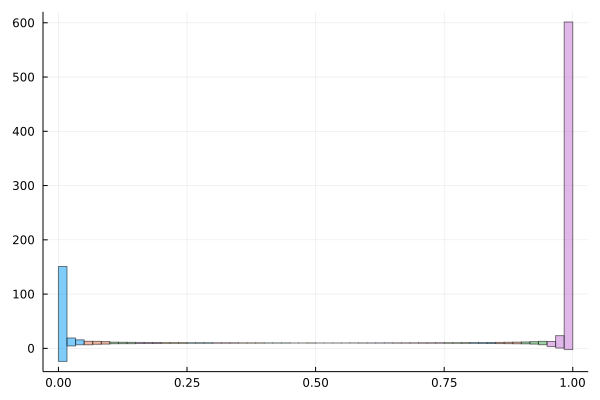

In [92]:
# vykreslení řešení aproximovaného přes kubický spline

xn = 3

p = plot()
for i in 1:length(u2i)-1
    x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
    x_int = mince(x_dom,xn)
    jmenovatel(x) = csc_u1[i][1]*(x-ti[i])^3 + csc_u1[i][2]*(x-ti[i])^2 + csc_u1[i][3]*(x-ti[i]) + csc_u1[i][4]
    f(x) = -(csc_u2der[i][1]*(x-ti[i])^2 + csc_u2der[i][2]*(x-ti[i]) + csc_u2der[i][3])
    g(x) = f(x)/jmenovatel(x)
    boxes = IntervalBox.(x_int, g.(x_int))    
    if i == length(u2i)-1
        println(boxes[end])
    end
    plot!(boxes, legend=false)
end
p

[0.202929, 0.371507]
[0.000945521, 0.00605497]
[0.994999, 1] × [33.5144, 392.912]
Dolní odhad λ₁: -23.92584556780971
Chyba proti přesné hodnotě λ₁: 33.795449968899064


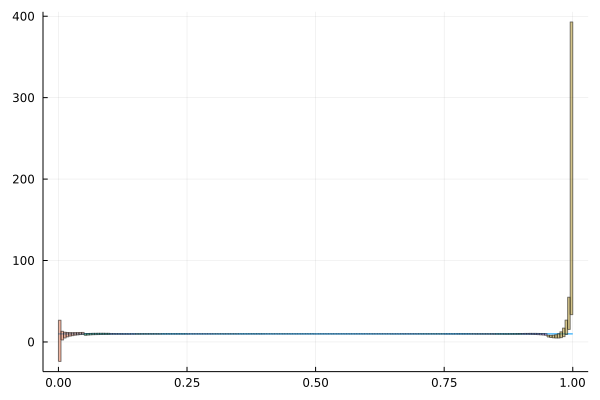

In [93]:
# výpočet λ₁ - dolní odhad

# vykreslení řešení aproximovaného přes kubický spline

ls = []

xn = 10

p = plot(t, [λ1 for i in t])
for i in 1:length(u2i)-1
    x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
    x_int = mince(x_dom,xn)
    
    u1_spl(x) = csc_u1[i][1]*(x-ti[i])^3 + csc_u1[i][2]*(x-ti[i])^2 + csc_u1[i][3]*(x-ti[i]) + csc_u1[i][4]

    u2der_spl(x) = -(csc_u2der[i][1]*(x-ti[i])^2 + csc_u2der[i][2]*(x-ti[i]) + csc_u2der[i][3])
    #f(x)         = -(csc_u2der[i][1]*(x-ti[i])^2 + csc_u2der[i][2]*(x-ti[i]) + csc_u2der[i][3])    

    f(x) = u2der_spl(x) / u1_spl(x) #^(P-1)
    #println(-v_spl_der_i(x_int[1]))
    #println(u_spl_i(x_int[1]))
    boxes = IntervalBox.(x_int, f.(x_int))    
    
    if i == length(u2i)-1
        println(u2der_spl(x_int[end]))
        println(u1_spl(x_int[end]))        
        println(boxes[end])
    end
    
    plot!(boxes, legend=false)
    # kromě vykreslení sem musím ještě dodat záznam minim
    append!(ls, inf.(f.(x_int)))
    
end
println("Dolní odhad λ₁: $(minimum(ls))")
println("Chyba proti přesné hodnotě λ₁: $(λ1 - minimum(ls))")
p


# Spline přes DataInterpolations.jl

- neumi ale nastavit druhou derivaci na koncích, navíc to neni intervalově :-(

In [129]:
# proložení splinem - pomocí DataInterpolations
# tady si ale nejsem schopen nastavit správně krajní záporné druhé derivace

u_spl = CubicSpline(u1,t);
v_spl = CubicSpline(u2,t);


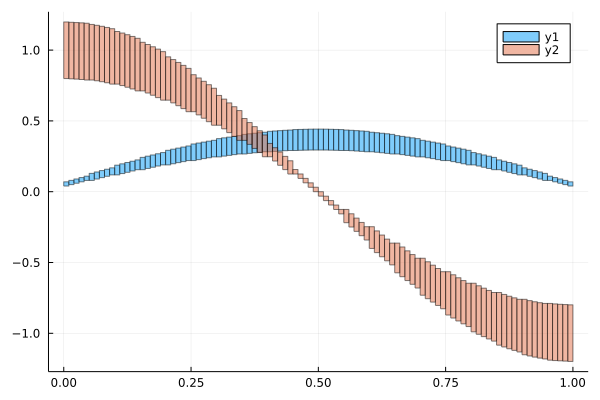

In [130]:
#vykreslení funkce intervalově
x_dom = 0..1
x_int = mince(x_dom,100)

boxes_u = IntervalBox.(x_int, u_spl.(x_int))
boxes_v = IntervalBox.(x_int, v_spl.(x_int))
plot(boxes_u)
plot!(boxes_v)

In [131]:
v_spl_der(x) = ForwardDiff.derivative(v_spl,x)

v_spl_der (generic function with 1 method)

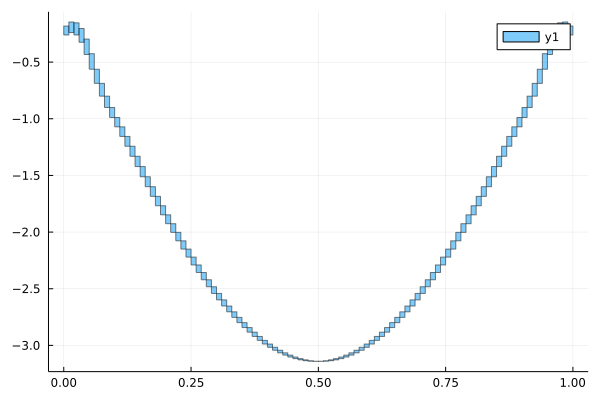

In [132]:
x_dom = 0..1
x_int = mince(x_dom,100)

boxes = IntervalBox.(x_int, v_spl_der.(x_int))
plot(boxes)

In [133]:
l_low(x) = -v_spl_der(x) / u_spl(x)^(P-1)

l_low (generic function with 1 method)

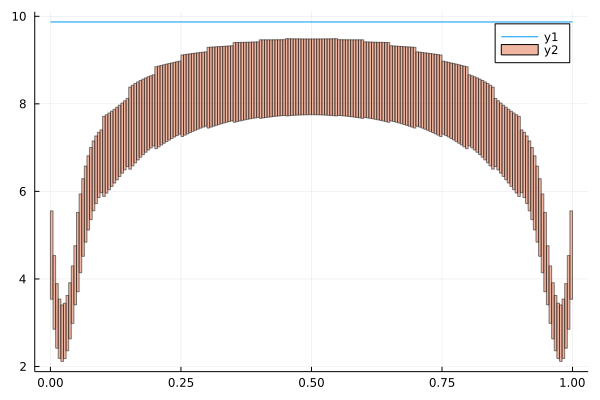

In [143]:
x_dom = 0..1
x_int = mince(x_dom,200)

boxes = IntervalBox.(x_int, l_low.(x_int))
plot(t, [λ1 for i in t])
plot!(boxes)


In [141]:
l_low(0..1)

[-∞, ∞]